### 1. Import

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.datasets import CIFAR10

/home/yukik/.pyenv/versions/3.10.7/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. Dataset

In [2]:

transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                transforms.Resize((224, 224))])

train_dataset = CIFAR10(root='data', 
                        train=True, 
                        transform=transform,
                        download=True)
train_dataset, val_dataset = random_split(train_dataset, [40000, 10000])
test_dataset = CIFAR10(root='data', 
                        train=False, 
                        transform=transform,
                        download=True)

Files already downloaded and verified
Files already downloaded and verified


### 3.　可視化

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


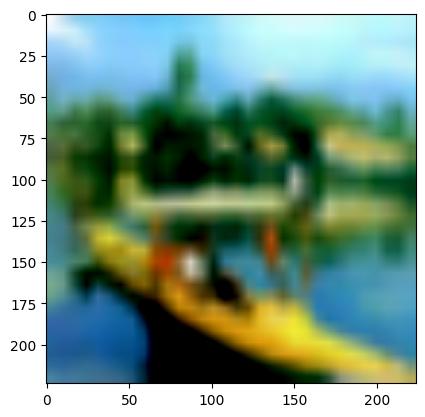

In [3]:
import matplotlib.pyplot as plt

plt.imshow(train_dataset[4][0].permute(1, 2, 0))
plt.show()
plt.close()

### 4. Data Loader

In [4]:
train_loader = DataLoader(dataset=train_dataset, batch_size=128, num_workers=4, shuffle=True)
val_loader   = DataLoader(dataset=val_dataset,   batch_size=128, num_workers=4, shuffle=False)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=128, num_workers=4, shuffle=False)

### 5. ViTを実装する

In [5]:
import timm

In [6]:
model_names = timm.list_models(pretrained=True)
for model_name in model_names:
    if model_name.startswith('vit'):
        print(model_name)

vit_base_patch8_224.augreg2_in21k_ft_in1k
vit_base_patch8_224.augreg_in21k
vit_base_patch8_224.augreg_in21k_ft_in1k
vit_base_patch8_224.dino
vit_base_patch14_dinov2.lvd142m
vit_base_patch16_224.augreg2_in21k_ft_in1k
vit_base_patch16_224.augreg_in1k
vit_base_patch16_224.augreg_in21k
vit_base_patch16_224.augreg_in21k_ft_in1k
vit_base_patch16_224.dino
vit_base_patch16_224.mae
vit_base_patch16_224.orig_in21k_ft_in1k
vit_base_patch16_224.sam_in1k
vit_base_patch16_224_miil.in21k
vit_base_patch16_224_miil.in21k_ft_in1k
vit_base_patch16_384.augreg_in1k
vit_base_patch16_384.augreg_in21k_ft_in1k
vit_base_patch16_384.orig_in21k_ft_in1k
vit_base_patch16_clip_224.laion2b
vit_base_patch16_clip_224.laion2b_ft_in1k
vit_base_patch16_clip_224.laion2b_ft_in12k
vit_base_patch16_clip_224.laion2b_ft_in12k_in1k
vit_base_patch16_clip_224.openai
vit_base_patch16_clip_224.openai_ft_in1k
vit_base_patch16_clip_224.openai_ft_in12k
vit_base_patch16_clip_224.openai_ft_in12k_in1k
vit_base_patch16_clip_384.laion2b_ft_

In [7]:
model = timm.create_model('vit_base_patch16_224.orig_in21k_ft_in1k', pretrained=True, num_classes=10)
model.to("cuda:0")

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [9]:
# パラメータカウント
params = 0
for p in model.parameters():
    if p.requires_grad:
        params += p.numel()
        
print(f'The Number of params = {params/10**6}M')

The Number of params = 85.806346M


### 6. 学習

In [10]:
from torch.optim import SGD
from sklearn.metrics import accuracy_score

criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.01)

model.zero_grad()

EPOCHS = 10

for epoch in range(EPOCHS):
    train_loss = []
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        
        images = images.to("cuda:0")
        labels = labels.to("cuda:0")
        
        preds = model(images)
        
        loss = criterion(preds, labels)
        train_loss.append(loss.item())
        
        loss.backward()
        optimizer.step()

        if i%10 == 0:
            print(f'Epoch: {epoch+1}, Batch: {i}, Loss: {loss.item():.4f}')
            
    val_loss = []
    acc_list = []
    model.eval()
    for i, (images, labels) in enumerate(val_loader):
        images = images.to("cuda:0")
        labels = labels.to("cuda:0")
        
        preds = model(images)
        loss = criterion(preds, labels)
        val_loss.append(loss.item())
        
        acc = accuracy_score(labels.to('cpu'), preds.to('cpu').argmax(dim=1))
        acc_list.append(acc)
        
    print(f'Epoch: {epoch+1}, '\
          + f'Train Loss: {sum(train_loss)/len(train_loss):.4f}, '
          + f'Val Loss: {sum(val_loss)/len(val_loss):.4f}, '
          + f'Val Acc: {sum(acc_list)/len(acc_list):.4f}')

Epoch: 1, Batch: 1, Loss: 2.5172
Epoch: 1, Batch: 11, Loss: 1.3126
Epoch: 1, Batch: 21, Loss: 0.6067
Epoch: 1, Batch: 31, Loss: 0.4254
Epoch: 1, Batch: 41, Loss: 0.3036
Epoch: 1, Batch: 51, Loss: 0.2301
Epoch: 1, Batch: 61, Loss: 0.1740
Epoch: 1, Batch: 71, Loss: 0.2088
Epoch: 1, Batch: 81, Loss: 0.1669
Epoch: 1, Batch: 91, Loss: 0.0785
Epoch: 1, Batch: 101, Loss: 0.1500
Epoch: 1, Batch: 111, Loss: 0.1467
Epoch: 1, Batch: 121, Loss: 0.1124
Epoch: 1, Batch: 131, Loss: 0.0648
Epoch: 1, Batch: 141, Loss: 0.0836
Epoch: 1, Batch: 151, Loss: 0.1199
Epoch: 1, Batch: 161, Loss: 0.1551
Epoch: 1, Batch: 171, Loss: 0.1002
Epoch: 1, Batch: 181, Loss: 0.0950
Epoch: 1, Batch: 191, Loss: 0.1196
Epoch: 1, Batch: 201, Loss: 0.0565
Epoch: 1, Batch: 211, Loss: 0.0877
Epoch: 1, Batch: 221, Loss: 0.1221
Epoch: 1, Batch: 231, Loss: 0.0513
Epoch: 1, Batch: 241, Loss: 0.0514
Epoch: 1, Batch: 251, Loss: 0.0797
Epoch: 1, Batch: 261, Loss: 0.0699
Epoch: 1, Batch: 271, Loss: 0.0526
Epoch: 1, Batch: 281, Loss: 0.0

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.